In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
!wget -nc -q https://lazyprogrammer.me/course_files/spam.csv

In [30]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
# Drop & rename cols
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ['label', 'data']
# Create binary classes
labels = ['ham', 'spam']
df['y'] = df['label'].map(dict(zip(labels, range(2))))
# Train test split
x_train, x_test, y_train, y_test = train_test_split(df['data'].values, df['y'].values, test_size=0.33)

df.head()

,label,data,y
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
# Fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
V = 1 + len(tokenizer.word_index)
print(f'Unique tokens (incl. padding): {V}')
# Apply tokenizer
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
# Apply padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train)
T = X_train.shape[1]
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=T)
print(f'Sequences length (with padding): {T}')

Unique tokens (incl. padding): 7370
Sequences length (with padding): 189


In [5]:
D = 20  # embedding dimensionality

i = tf.keras.Input(shape=(T,))
x = tf.keras.layers.Embedding(V, D)(i)
x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(1)(x)
m = tf.keras.Model(i, x)

m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 embedding (Embedding)       (None, 189, 20)           147400    
                                                                 
 conv1d (Conv1D)             (None, 187, 32)           1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 91, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 45, 64)           0         
 1D)                                                         

In [6]:
m.compile(
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'])

r = m.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
117/117 [==============================] - 9s 63ms/step - loss: 0.4019 - accuracy: 0.8615 - val_loss: 0.2910 - val_accuracy: 0.8749
Epoch 2/10
117/117 [==============================] - 7s 60ms/step - loss: 0.1678 - accuracy: 0.9164 - val_loss: 0.0881 - val_accuracy: 0.9739
Epoch 3/10
117/117 [==============================] - 8s 68ms/step - loss: 0.0238 - accuracy: 0.9904 - val_loss: 0.0676 - val_accuracy: 0.9788
Epoch 4/10
117/117 [==============================] - 5s 43ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.0919 - val_accuracy: 0.9782
Epoch 5/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0883 - val_accuracy: 0.9793
Epoch 6/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.1006 - val_accuracy: 0.9799
Epoch 7/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0885 - val_accuracy: 0.9788

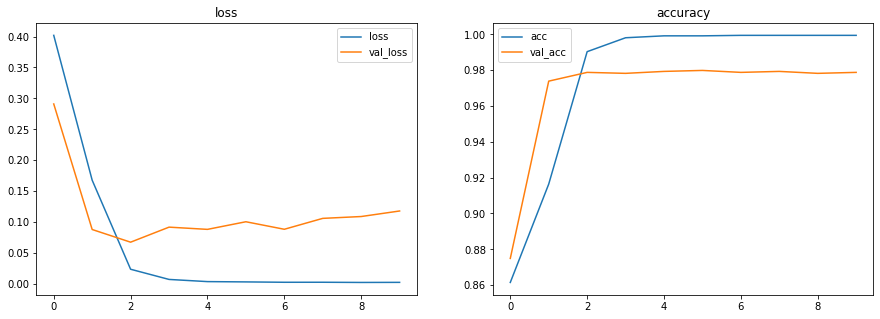

In [7]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(r.history['loss'], label='loss')
ax[0].plot(r.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(r.history['accuracy'], label='acc')
ax[1].plot(r.history['val_accuracy'], label='val_acc')
ax[1].set_title('accuracy')
ax[1].legend();

In [37]:
y_ != y_test

array([False,  True, False, ..., False, False, False])

In [44]:
# Show some misclassified examples
y_ = 1*(m.predict(X_test).flatten() > 0)  # positive is class 1, negative is class 0
misclassified = y_ != y_test

false_positives = np.where(np.logical_and(misclassified, (y_test == 0)))[0]
print(f'\nFalse positives (true: {labels[0]}, predicted: {labels[1]})')
for _ in range(5):
  print('  ' + x_test[np.random.choice(false_positives)])

false_negatives = np.where(np.logical_and(misclassified, (y_test == 1)))[0]
print(f'\nFalse negatives (true: {labels[1]}, predicted: {labels[0]})')
for _ in range(5):
  print('  ' + x_test[np.random.choice(false_negatives)])

58/58 [==============================] - 1s 11ms/step

False positives (true: ham, predicted: spam)
  Gosh that , what a pain. Spose I better come then.
  Oh ok..
  Evening * v good if somewhat event laden. Will fill you in, don't you worry Û_ Head * ok but throat * wrecked. See you at six then!
  Fighting with the world is easy, u either win or lose bt fightng with some1 who is close to u is dificult if u lose - u lose if u win - u still lose.
  , ,  and  picking them up from various points | going 2 yeovil | and they will do the motor project 4 3 hours | and then u take them home. || 12 2 5.30 max. || Very easy

False negatives (true: spam, predicted: ham)
  Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16
  This message is free. Welcome to the new & improved Sex & Dogging club! To unsubscribe from this service reply STOP. msgs@150p 18+only
  Urgent! call 09066350750 from your landl